In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Markov Models')

In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
class HMM:
    def __init__(self, M):
        self.M = M  #number of hidden states
    
    def set_session(self, session):
        self.session = session

    def fit(self, X, max_iter=10, print_period=1):
        #train hidden markov model with stochastic gradient descent

        N = len(X)
        print("Number of train samples:", N)

        costs = []
        for it in range(max_iter):
            if it % print_period == 0:
                print('it:', it)
            for n in range(N):
                #this would ofcoure be much fasterif we didnt do this on every
                #iteration of the loop
                c = self.get_cost_multi(X).sum()
                costs.append(c)
                self.session.run(self.train_op, feed_dict={self.tfx: X[n]})

        plt.plot(costs)
        plt.show()

    def get_cost(self, x):
        #returns log P(x|model)
        #using the forward part of the forward-backward algorithm 
        #print("getting cost for:", x)
        return self.session.run(self.cost, feed_dict={self.tfx: x})

    def log_likelihood(self, x):
        return -self.session.run(self.cost, feed_dict={self.tfx: x})

    def get_cost_multi(self, X):
        return np.array([self.get_cost(x) for x in X])

    

    def build(self, preSoftmaxPi, preSoftmaxA, preSoftmaxB):
        M, V = preSoftmaxB.shape

        self.preSoftmaxPi = tf.Variable(preSoftmaxPi)
        self.preSoftmaxA = tf.Variable(preSoftmaxA)
        self.preSoftmaxB = tf.Variable(preSoftmaxB)

        pi = tf.nn.softmax(self.preSoftmaxPi)
        A = tf.nn.softmax(self.preSoftmaxA)
        B = tf.nn.softmax(self.preSoftmaxB)

        #define cost
        self.tfx = tf.placeholder(tf.int32, shape=(None,), name='x')


        def recurrence(old_a_old_s, x_t):
            old_a = tf.reshape(old_a_old_s[0], (1, M))
            a = tf.matmul(old_a, A) * B[:, x_t]
            a = tf.reshape(a, (M,))
            s = tf.reduce_sum(a)
            return (a / s), s

        # remember, tensorflow scan is going to loop through
        # all the values!
        # we treat the first value differently than the rest
        # so we only want to loop through tfx[1:]
        # the first scale being 1 doesn't affect the log-likelihood
        # because log(1) = 0
        alpha, scale = tf.scan(fn=recurrence, elems=self.tfx[1:],
                            initializer = (pi*B[:,self.tfx[0]],np.float32(1.0)),)
        
       
        self.cost = -tf.reduce_sum(tf.log(scale))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)

    def init_random(self, V):
        preSoftmaxPi0 = np.zeros(self.M).astype(np.float32) #initial state distribution
        preSoftmaxA0 = np.random.randn(self.M, self.M).astype(np.float32) #state transition matrix
        preSoftmaxB0 = np.random.randn(self.M, V).astype(np.float32) #output distribution
        
        self.build(preSoftmaxPi0, preSoftmaxA0, preSoftmaxB0)

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxB):
        op1 = self.preSoftmaxPi.assign(preSoftmaxPi)
        op2 = self.preSoftmaxA.assign(preSoftmaxA)
        op3 = self.preSoftmaxB.assign(preSoftmaxB)
        self.session.run([op1, op2, op3])

In [0]:
def fit_coin():
    X = []
    for line in open('coin_data.txt'):
        #1 for H, 0 for T
        x = [1 if e == 'H' else 0 for e in line.rstrip()] 
        X.append(x)
    # X = np.array(X).astype(np.int32)

    hmm = HMM(2)
    #the entire graph, including optmizer's variables, must be built
    #before calling global variables initializer
    hmm.init_random(2)
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        hmm.set_session(session)
        hmm.fit(X, max_iter=5)
        L = hmm.get_cost_multi(X).sum()
        print("LL with fitted params:", L)

        #try true values
        #remember these must be in their "pre-softmax" forms
        pi = np.log(np.array([0.5, 0.5])).astype(np.float32)
        A = np.log(np.array([[0.1, 0.9], [0.8, 0.2]])).astype(np.float32)
        B = np.log(np.array([[0.6, 0.4], [0.3, 0.7]])).astype(np.float32)
        hmm.set(pi, A, B)
        L = hmm.get_cost_multi(X).sum()
        print("LL with true params:", L)


Number of train samples: 50
it: 0
it: 1
it: 2
it: 3
it: 4


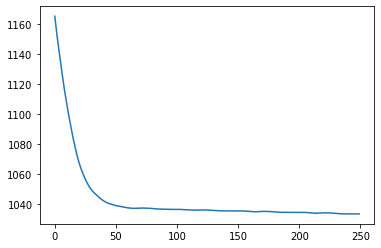

LL with fitted params: 1033.5061
LL with true params: 1059.7229


In [111]:
if __name__ =='__main__':
    fit_coin()